In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.formula.api import glm
from scipy.optimize import minimize
from scipy.stats import nbinom
from scipy.stats import rankdata
import gzip 
import subprocess
import urllib.request
import requests
import shutil
import re
from sklearn.impute import SimpleImputer

In [5]:
# Charger le fichier TSV avec pandas
batch1 = pd.read_csv('Counts_GSE106608.tsv', delimiter='\t')
batch2 = pd.read_csv('Counts_GSE133101.tsv', delimiter='\t')
batch3 = pd.read_csv('Counts_GSE134390.tsv', delimiter='\t')
batch4 = pd.read_csv('Counts_GSE135036.tsv', delimiter='\t')
batch5 = pd.read_csv('Counts_GSE136666.tsv', delimiter='\t')

# Convertir les données en tableau NumPy

batch1=batch1.head(100)
batch2=batch2.head(100)
batch3=batch3.head(100)
batch4=batch4.head(100)
batch5=batch5.head(100)

batch1 = batch1.to_numpy()
batch2 = batch2.to_numpy()
batch3 = batch3.to_numpy()
batch4 = batch4.to_numpy()
batch5 = batch5.to_numpy()

batch1=batch1[:, 1:]
batch2=batch2[:, 1:]
batch3=batch3[:, 1:]
batch4=batch4[:, 1:]
batch5=batch5[:, 1:]

batch1=batch1.transpose()
batch2=batch2.transpose()
batch3=batch3.transpose()
batch4=batch4.transpose()
batch5=batch5.transpose()
print(batch2)


[[139 0 158 ... 91 58 66]
 [79 0 332 ... 227 196 174]
 [276 0 535 ... 478 219 264]
 ...
 [109 0 220 ... 277 115 115]
 [102 0 297 ... 383 69 173]
 [142 0 635 ... 862 177 301]]


In [6]:
def estimate_group_effects(counts):
    mean_counts = np.mean(counts, axis=1)
    disp_common = np.mean((counts.T - mean_counts) ** 2 / (mean_counts+0.000000000001), axis=1)
    print(disp_common)
    return disp_common

def equalize_matrix_size(matrix_list):
    max_columns = max(matrix.shape[1] for matrix in matrix_list)
    equalized_list = []
    
    for matrix in matrix_list:
        num_rows = matrix.shape[0]
        num_columns = matrix.shape[1]
        
        if num_columns < max_columns:
            mean_rows = np.mean(matrix, axis=1)
            mean_rows = np.expand_dims(mean_rows, axis=1)
            mean_rows = np.tile(mean_rows, (1, max_columns - num_columns))
            matrix = np.hstack((matrix, mean_rows))
        
        equalized_list.append(matrix)
    
    return equalized_list



def combine_group_effects(batch_group_effects):
    batch_group_effect=equalize_matrix_size(batch_group_effects)
    batch_group_effect=np.mean(batch_group_effect, axis=0)

In [7]:
batch1_effect=estimate_group_effects(batch1)
batch2_effect=estimate_group_effects(batch2)
batch3_effect=estimate_group_effects(batch3)
batch4_effect=estimate_group_effects(batch4)
batch5_effect=estimate_group_effects(batch5)

total_group=[batch1_effect, batch2_effect, batch3_effect, batch4_effect, batch5_effect]
total_group
#total_group=equalize_matrix_size(total_group)
#total_group[3].shape[1]
#average_group_effect=combine_group_effects(total_group)
average_group_effect=np.mean(total_group, axis=0)

[307.80897225583055 505.1045608086446 371.8925908601448 348.78980830733025
 245.48120216705257 395.4967743957949 8975.96642211138 199.98775347493887
 3260.7913318672454 77.40403030597219 300.0365742998117 849.5684541119662
 35.7591778048995 87.74247728054353 339.256224357442 324.7338698948449
 16355.296835251076 582.8634832962281 3913.6635312746666 162.9335580569142
 509.4322619128316 386.8202691752354 261.3956281655225 289.75857062157723
 289.75857062157723 487.33232209499124 509.806249999999 504.8891081144515
 291.6677396767741 295.3173852241076 118.34200054743349 292.02766078832144
 345.03344277343507 21.953399934932815 118.19300986901453
 473.30888478703525 103.08897772007799 412.91486394655897
 2284.647203691192 343.03350179968214 383.4684766840537 445.66024609643557
 89.27853584251427 5787.270993650623 366.75580708005805 255.22842842529454
 175.019084912769 346.17110492055343 61.4764324382747 323.6153430818558
 5854.693813679841 283.0081077487977 6054.059165385306 69.208402192754

In [8]:
def calculate_common_dispersion(counts):
    n_genes = counts.shape[1]
    disp_values = np.empty(n_genes)
    
    for i in range(n_genes):
        gene_counts = counts[:, i]
        gene_disp = sm.robust.scale.mad(gene_counts)
        disp_values[i] = gene_disp
    
    return disp_values

def average_common_dispersion(data_batches):
    average_dispersion = np.mean(data_batches, axis=0)
    return average_dispersion

In [9]:
batch1_variance=calculate_common_dispersion(batch1)
batch2_variance=calculate_common_dispersion(batch2)
batch3_variance=calculate_common_dispersion(batch3)
batch4_variance=calculate_common_dispersion(batch4)
batch5_variance=calculate_common_dispersion(batch5)
common_gene_disp=[batch1_variance, batch2_variance, batch3_variance, batch4_variance, batch5_variance]
average_gene_disp=average_common_dispersion(common_gene_disp)
print(average_gene_disp)

[7.60574938e+01 4.44780666e-01 2.15718623e+02 5.94523490e+01
 5.29288992e+01 3.40998510e+01 4.39888078e+02 1.69016653e+02
 4.69391862e+02 2.51449336e+02 7.41301109e+01 1.19898041e+03
 2.11567337e+02 6.13797318e+02 4.80363119e+01 3.75098361e+01
 1.00253562e+03 7.19803377e+02 4.80363119e+02 1.03930416e+02
 2.96520444e-01 8.76217911e+01 3.45001536e+02 3.62199722e+02
 3.62199722e+02 2.60937990e+01 0.00000000e+00 6.37518954e+00
 3.49152822e+02 9.19213375e+01 3.89034822e+02 9.63691442e+01
 9.35522000e+01 3.28989432e+02 2.61086251e+02 9.78517464e+01
 1.98372177e+02 1.31951597e+02 4.53972799e+02 3.78063566e+01
 5.09422122e+02 2.60937990e+01 1.59972779e+02 8.49975852e+02
 3.72281417e+02 2.94889581e+02 3.05860838e+02 1.50187605e+02
 2.63903195e+02 3.86662659e+02 5.27065089e+02 1.11343427e+02
 7.93192187e+02 3.19797299e+02 6.12907757e+02 5.26620308e+02
 1.29134653e+02 3.87552220e+02 6.28623341e+01 1.76874445e+02
 2.04747366e+02 7.42635451e+02 1.33434200e+00 5.01119550e+01
 0.00000000e+00 3.217246

In [10]:
def adjust_data(data, group_effects, common_dispersion):
    adjusted_data = np.zeros_like(data)
    for i in range(len(data[0])):
        adjusted_data[:, i] = (data[:, i] - group_effects[i]) / np.sqrt(common_dispersion[i]+0.0000000001)
    
    return adjusted_data        

In [11]:
batch1_adjusted=adjust_data(batch1, average_group_effect, average_gene_disp)
batch2_adjusted=adjust_data(batch2, average_group_effect, average_gene_disp)
batch3_adjusted=adjust_data(batch3, average_group_effect, average_gene_disp)
batch4_adjusted=adjust_data(batch4, average_group_effect, average_gene_disp)
batch5_adjusted=adjust_data(batch5, average_group_effect, average_gene_disp)
print(batch1_adjusted)
batch1[:10]

[[-24.323518405938945 -825.3817940257716 17.01626465738521 ...
  -10.336141327442016 -43.29773014520576 -25.617931776962134]
 [-14.577035614375449 -817.8846292836594 54.05490879490658 ...
  8.568774378307571 -38.52022199889303 -21.060870667558994]
 [-6.779849381124652 -813.3863304383921 46.701648561722195 ...
  4.131906406550015 -40.02172455916275 -14.345201664228053]
 ...
 [-23.864860392218308 -825.3817940257716 18.309893772482464 ...
  -6.7673562197239825 -45.07223317097907 -27.536694349342405]
 [3.081297913869001 -823.8823610773491 25.254639548267722 ...
  -7.249624477523716 -40.02172455916275 -22.140174614522895]
 [-19.163615751581798 -825.3817940257716 56.7783385109008 ...
  -8.021253690003292 -38.52022199889303 -14.944814968096887]]


array([[55, 0, 386, 64, 89, 15, 725, 107, 1067, 122, 107, 537, 397, 161,
        110, 72, 1333, 401, 816, 145, 0, 59, 389, 385, 385, 20, 0, 2,
        753, 77, 238, 63, 55, 327, 349, 8, 713, 93, 995, 33, 341, 17,
        353, 1282, 625, 131, 164, 66, 441, 305, 1253, 83, 825, 396, 1558,
        119, 123, 409, 10, 92, 194, 180, 1, 4, 0, 0, 595, 187, 440, 4, 4,
        151, 102, 2, 202, 146, 445, 8, 0, 353, 134, 0, 419, 229, 269, 3,
        38, 139, 150, 50, 23, 107, 150, 2659, 766, 26, 14, 104, 25, 70],
       [140, 5, 930, 121, 226, 30, 1500, 215, 2223, 421, 118, 1384, 846,
        591, 33, 350, 4600, 1230, 2398, 266, 0, 78, 809, 441, 441, 4, 0,
        0, 577, 174, 306, 146, 88, 743, 409, 18, 522, 28, 2149, 109, 864,
        16, 870, 3268, 1149, 67, 294, 134, 756, 778, 2986, 281, 1091,
        853, 3099, 159, 305, 1165, 19, 372, 502, 734, 0, 10, 3, 17, 2363,
        291, 1078, 5, 22, 306, 234, 0, 496, 307, 738, 26, 0, 667, 233, 0,
        472, 407, 601, 2, 47, 240, 312, 96, 50, 302, 33

C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\3559357963.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette=cols, ax=ax)
C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\3559357963.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df2, x='PC1', y='PC2', palette=cols, ax=ax)
C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\3559357963.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df3, x='PC1', y='PC2', palette=cols, ax=ax)
C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\3559357963.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df4, x='PC1', y='PC2', palette=cols, ax=ax)
C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\3559357963.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been as

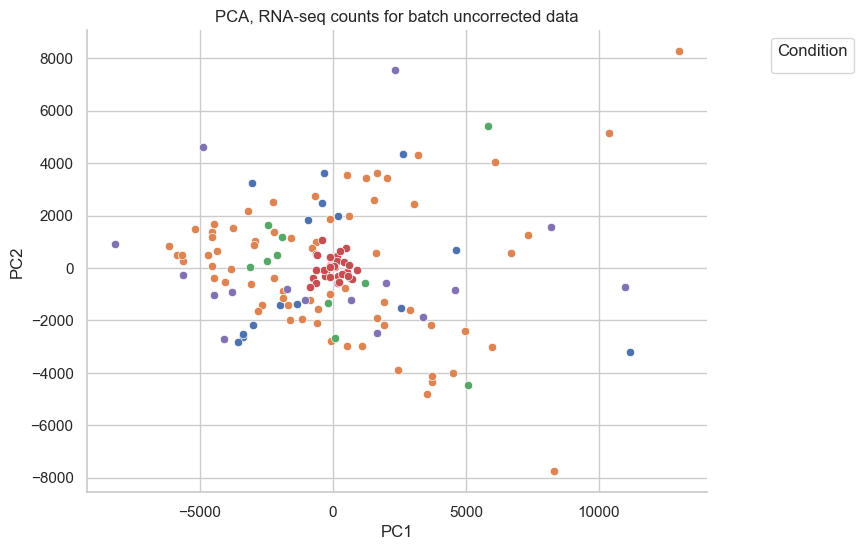

In [12]:
# Création du graphique en nuage de points
# Perform PCA
pca_uncorrected_obj = PCA()
pca_uncorrected = pca_uncorrected_obj.fit_transform(batch1)
pca_uncorrected2 = pca_uncorrected_obj.fit_transform(batch2)
pca_uncorrected3 = pca_uncorrected_obj.fit_transform(batch3)
pca_uncorrected4 = pca_uncorrected_obj.fit_transform(batch4)
pca_uncorrected5 = pca_uncorrected_obj.fit_transform(batch5)

# Create DataFrame from PCA results
pca_df = pd.DataFrame(pca_uncorrected[:, :2], columns=['PC1', 'PC2'])
pca_df2 = pd.DataFrame(pca_uncorrected2[:, :2], columns=['PC1', 'PC2'])
pca_df3 = pd.DataFrame(pca_uncorrected3[:, :2], columns=['PC1', 'PC2'])
pca_df4 = pd.DataFrame(pca_uncorrected4[:, :2], columns=['PC1', 'PC2'])
pca_df5 = pd.DataFrame(pca_uncorrected5[:, :2], columns=['PC1', 'PC2'])


# Define color palette for conditions
cols = {"UHR": "#481567FF", "HBR": "#1F968BFF"}

# Plot the PCA
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette=cols, ax=ax)
sns.scatterplot(data=pca_df2, x='PC1', y='PC2', palette=cols, ax=ax)
sns.scatterplot(data=pca_df3, x='PC1', y='PC2', palette=cols, ax=ax)
sns.scatterplot(data=pca_df4, x='PC1', y='PC2', palette=cols, ax=ax)
sns.scatterplot(data=pca_df5, x='PC1', y='PC2', palette=cols, ax=ax)
sns.despine()
ax.set_title("PCA, RNA-seq counts for batch uncorrected data")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(title="Condition", loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

# Save the plot to a PDF file
fig.savefig("Uncorrected-vs-BatchCorrected-PCA.pdf")
# Affichage du graphique
plt.show()

C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\2230105649.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette=cols, ax=ax)
C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\2230105649.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df2, x='PC1', y='PC2', palette=cols, ax=ax)
C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\2230105649.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df3, x='PC1', y='PC2', palette=cols, ax=ax)
C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\2230105649.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pca_df4, x='PC1', y='PC2', palette=cols, ax=ax)
C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\2230105649.py:26: UserWarning: Ignoring `palette` because no `hue` variable has been as

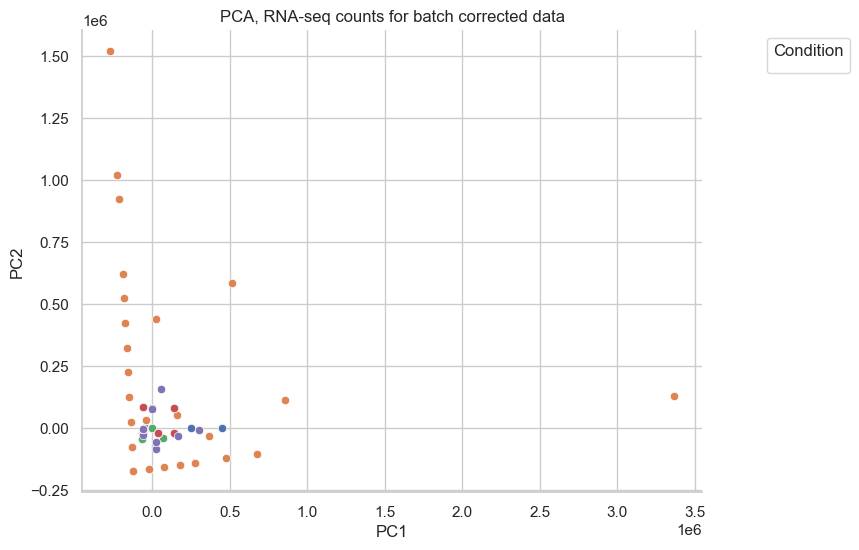

In [18]:
# Perform PCA on corrected data
pca_corrected_obj = PCA()
pca_corrected = pca_corrected_obj.fit_transform(batch1_adjusted)
pca_corrected2 = pca_corrected_obj.fit_transform(batch2_adjusted)
pca_corrected3 = pca_corrected_obj.fit_transform(batch3_adjusted)
pca_corrected4 = pca_corrected_obj.fit_transform(batch4_adjusted)
pca_corrected5 = pca_corrected_obj.fit_transform(batch5_adjusted)

# Create DataFrame from PCA results
pca_df = pd.DataFrame(pca_corrected[:, :2], columns=['PC1', 'PC2'])
pca_df2 = pd.DataFrame(pca_corrected2[:, :2], columns=['PC1', 'PC2'])
pca_df3 = pd.DataFrame(pca_corrected3[:, :2], columns=['PC1', 'PC2'])
pca_df4 = pd.DataFrame(pca_corrected4[:, :2], columns=['PC1', 'PC2'])
pca_df5 = pd.DataFrame(pca_corrected5[:, :2], columns=['PC1', 'PC2'])

# Define color palette for conditions
cols = {"UHR": "#481567FF", "HBR": "#1F968BFF"}

# Plot the PCA
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette=cols, ax=ax)
sns.scatterplot(data=pca_df2, x='PC1', y='PC2', palette=cols, ax=ax)
sns.scatterplot(data=pca_df3, x='PC1', y='PC2', palette=cols, ax=ax)
sns.scatterplot(data=pca_df4, x='PC1', y='PC2', palette=cols, ax=ax)
sns.scatterplot(data=pca_df5, x='PC1', y='PC2', palette=cols, ax=ax)
sns.despine()
ax.set_title("PCA, RNA-seq counts for batch corrected data")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(title="Condition", loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

# Save the plot to a PDF file
fig.savefig("Uncorrected-vs-BatchCorrected-PCA.pdf")

In [19]:
def construct_phi_matrix(counts, genewise_disp_lst):
    n_genes = counts.shape[1]
    n_samples = counts.shape[0]
    
    phi_matrix = np.full((n_genes, n_samples), np.nan)
    
    for k in range(n_samples):
        phi_matrix[:, k] = genewise_disp_lst
    
    return phi_matrix

In [20]:
phi_matrix=construct_phi_matrix(batch1, average_gene_disp)
phi_matrix=phi_matrix.transpose()

In [40]:
# Étape 1 : Ajuster le modèle GLM
mean_counts = np.mean(batch1, axis=1)
var_counts = np.var(batch1, axis=1)
p_hat = 1 - (var_counts / mean_counts)
r_hat = mean_counts / (1 - p_hat)

# Calcul de alpha_g (moyenne pondérée par la taille du lot)
alpha_g = np.dot(r_hat, 1 / batch1.shape[0])

# Calcul du nouvel offset
for i in range(len(batch1.mean(axis=1))):
    batch1.mean(axis=1)[i]=np.log(batch1.mean(axis=1)[i])
offset = batch1.mean(axis=1)[:, np.newaxis] + alpha_g[:, np.newaxis]

offset = np.array(offset, dtype=int)
print('\nOffset')
print(offset)

def negative_log_likelihood(params):
    params_adjusted = np.repeat(params[:, np.newaxis], batch1.shape[1], axis=1)
    log_mu = offset + np.dot(batch1, params_adjusted.transpose())
    log_likelihood = nbinom.logpmf(batch1.astype(float), params[0].astype(float), params[1].astype(float))
    return -np.sum(log_likelihood)


params_initial = np.array([r_hat.mean(), p_hat.mean()])
params_initial_adjusted = np.repeat(params_initial[:, np.newaxis], batch1.shape[1], axis=1)


result = minimize(negative_log_likelihood, params_initial, method='L-BFGS-B')
gamma_hat = result.x
print('\nGamma_hat')
print(gamma_hat)
print(gamma_hat.shape)

# Calcul de mu_hat
gamma_hat_reshaped = np.tile(gamma_hat, (batch1.shape[1], 1)).T
print('\ngamma_hat_reshpaed')
print(gamma_hat_reshaped.shape)
a = np.dot(batch1, gamma_hat_reshaped.transpose())
a = np.array(a, dtype=int)

mu_hat = np.exp(offset) * np.exp(a)

print('\nMu_hat')
print(mu_hat)
# Calcul de phi_hat
phi_hat = np.column_stack(average_gene_disp)
print(phi_hat)


Offset
[[286]
 [594]
 [539]
 [614]
 [573]
 [293]
 [536]
 [418]
 [276]
 [761]
 [706]
 [253]
 [543]
 [522]
 [390]
 [846]]

Gamma_hat
[ 4.12253396e-01 -1.32766430e+03]
(2,)

gamma_hat_reshpaed
(2, 100)
\Mu_hat
[[inf  0.]
 [inf  0.]
 [inf  0.]
 [inf  0.]
 [inf  0.]
 [inf  0.]
 [inf  0.]
 [inf  0.]
 [inf  0.]
 [inf nan]
 [inf  0.]
 [inf  0.]
 [inf  0.]
 [inf  0.]
 [inf  0.]
 [inf nan]]
[[7.60574938e+01 4.44780666e-01 2.15718623e+02 5.94523490e+01
  5.29288992e+01 3.40998510e+01 4.39888078e+02 1.69016653e+02
  4.69391862e+02 2.51449336e+02 7.41301109e+01 1.19898041e+03
  2.11567337e+02 6.13797318e+02 4.80363119e+01 3.75098361e+01
  1.00253562e+03 7.19803377e+02 4.80363119e+02 1.03930416e+02
  2.96520444e-01 8.76217911e+01 3.45001536e+02 3.62199722e+02
  3.62199722e+02 2.60937990e+01 0.00000000e+00 6.37518954e+00
  3.49152822e+02 9.19213375e+01 3.89034822e+02 9.63691442e+01
  9.35522000e+01 3.28989432e+02 2.61086251e+02 9.78517464e+01
  1.98372177e+02 1.31951597e+02 4.53972799e+02 3.78063566

C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\1492019443.py:43: RuntimeWarning: overflow encountered in exp
  mu_hat = np.exp(offset) * np.exp(a)
C:\Users\noeam\AppData\Local\Temp\ipykernel_29436\1492019443.py:43: RuntimeWarning: invalid value encountered in multiply
  mu_hat = np.exp(offset) * np.exp(a)


In [16]:
uncorrected_data = pd.read_csv("GSE48035_ILMN.Counts.SampleSubset.ProteinCodingGenes.tsv",  sep='\t')

# Compter le nombre de lignes avec 18 éléments
nombre_colonnes = uncorrected_data.shape[1]
print(nombre_colonnes)

# Renommer les colonnes des données
uncorrected_data.columns = ["Gene", "Chr", "UHR_Ribo_1", "UHR_Ribo_2", "UHR_Ribo_3", "UHR_Ribo_4", "HBR_Ribo_1", "HBR_Ribo_2", "HBR_Ribo_3", "HBR_Ribo_4", 
                            "UHR_Poly_1", "UHR_Poly_2", "UHR_Poly_3", "UHR_Poly_4", "HBR_Poly_1", "HBR_Poly_2", "HBR_Poly_3", "HBR_Poly_4"]
sample_names = uncorrected_data.columns[2:]

# Définir les conditions, les méthodes de library, et les réplicats
conditions = ["UHR", "UHR", "UHR", "UHR", "HBR", "HBR", "HBR", "HBR", "UHR", "UHR", "UHR", "UHR", "HBR", "HBR", "HBR", "HBR"]
library_methods = ["Ribo", "Ribo", "Ribo", "Ribo", "Ribo", "Ribo", "Ribo", "Ribo", "Poly", "Poly", "Poly", "Poly", "Poly", "Poly", "Poly", "Poly"]
replicates = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
print(uncorrected_data[sample_names])
# Créer un imputeur pour remplacer les NaN par la moyenne des colonnes
imputer = SimpleImputer(strategy='mean')

# Remplacer les NaN dans uncorrected_data par la moyenne des colonnes
#uncorrected_data= uncorrected_data.iloc[:, 2:]
uncorrected_data_imputed = imputer.fit_transform(uncorrected_data.iloc[:,2:])

# Calculer les composantes principales pour les données non corrigées
pca_uncorrected = PCA(n_components=2).fit_transform(uncorrected_data_imputed[sample_names])


# Créer un DataFrame pour les résultats du PCA
pca_df = pd.DataFrame(pca_uncorrected, columns=["PC1", "PC2"])
pca_df["condition"] = conditions
pca_df["library_method"] = library_methods
pca_df["replicate"] = replicates

# Plot du PCA
colors = {"UHR": "#481567FF", "HBR": "#1F968BFF"}
fig, ax = plt.subplots()
for condition, color in colors.items():
    condition_data = pca_df[pca_df["condition"] == condition]
    ax.scatter(condition_data["PC1"], condition_data["PC2"], color=color, label=condition)
ax.set_title("PCA, RNA-seq counts for 16 HBR/UHR and Ribo/PolyA samples (uncorrected data)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
plt.show()

18
       UHR_Ribo_1  UHR_Ribo_2  UHR_Ribo_3  UHR_Ribo_4  HBR_Ribo_1  HBR_Ribo_2  \
0             527         357         310         446           7          12   
1           19596       13416        9255        9993        8658       10623   
2               8           2           6           7          14          10   
3               0          10           8           5           6           6   
4             481         281         311         522         648         373   
...           ...         ...         ...         ...         ...         ...   
16098        1568        1137         747        1193          41          50   
16099        8202        5769        5217        7918       17963       21682   
16100         130         133          73          83         281         407   
16101        3008        2132        1441        1634        4349        5341   
16102       10240        6822        6248        8874        6875        8104   

       HBR_Ribo_3  HBR_R

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [22]:
def match_quantiles(counts_sub, old_mu, old_phi, new_mu, new_phi):
    # Calcul des rangs des valeurs initiales
    ranks = rankdata(counts_sub, axis=0)
    
    # Calcul des quantiles pour les valeurs initiales
    quantiles = ranks / (counts_sub.shape[0] + 1)
    
    # Calcul des valeurs ajustées
    quantiles_adj = np.interp(quantiles, old_mu, new_mu)
    
    # Calcul des rangs correspondants aux quantiles ajustés
    ranks_adj = quantiles_adj * (counts_sub.shape[0] + 1)
    
    # Calcul des valeurs ajustées à partir des rangs
    counts_adj = np.interp(ranks_adj, np.arange(1, counts_sub.shape[0] + 1), counts_sub)
    
    return counts_adj


In [23]:
# Initialisation de mu_star avec des valeurs manquantes (NaN)

# Calcul de mu_star
print(mu_hat)
mu_star = np.exp(np.log(mu_hat+0.001) - np.tile(gamma_hat, (1, batch1.shape[1])))

# Calcul de phi_star
phi_star = np.mean(phi_hat)

# Ajustement des counts
adjust_counts = match_quantiles(batch1, mu_hat, phi_hat, mu_star, phi_star)


NameError: name 'mu_hat' is not defined